In [1]:
import os
from typing import List, Dict, NoReturn
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from skmultilearn.model_selection import iterative_train_test_split
import umap
from sklearn.metrics import make_scorer, accuracy_score, f1_score, zero_one_loss, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Locate files containing id and type of AMR
DATA_PATH = "/faststorage/project/amr_driams/rasmus/data/"
DRIAMS_PATHS = os.listdir(DATA_PATH)
ID_PATHS = []
for root, dir, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('clean.csv'):
            ID_PATHS.append(os.path.join(root, file))

print(ID_PATHS)


['/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2018_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2015_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2017_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2016_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-B/id/2018_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-C/id/2018_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-D/id/2018_clean.csv']


In [4]:
def stratified_split(csv_path, validation_size=0.10, species_column='species'):
    """
    Function to perform a stratified split of a given dataset and save the resulting sets to CSV files.

    Parameters:
    csv_path (str): Path to the CSV file.
    validation_size (float): Percentage of data to be used as the validation set.
    species_column (str): Column name for species in the dataset.

    Returns:
    tuple: Paths to the training/test set, validation set, and excluded samples set CSV files.

    """

    data_df = pd.read_csv(csv_path, low_memory=False)

    # Identify species labels that contain "MIX!" and treat them as another category to be excluded
    mix_species_mask = data_df[species_column].str.contains("MIX!")
    excluded_df = data_df[mix_species_mask]
    data_df = data_df[~mix_species_mask]
    
    # Identify unique species and their counts
    species_counts = data_df[species_column].value_counts()

    # Identify species with less than 5 members
    species_to_exclude = species_counts[species_counts < 5].index

    # Exclude single member species from the main data frame
    excluded_df = pd.concat([excluded_df, data_df[data_df[species_column].isin(species_to_exclude)]], ignore_index=True)
    stratified_df = data_df[~data_df[species_column].isin(species_to_exclude)]
    
    # Perform stratified sampling
    train_test_df, validation_df = train_test_split(
        stratified_df,
        test_size=validation_size,
        random_state=42,
        stratify=stratified_df[species_column]
    )

    # Save data frames
    base_path = csv_path.rsplit('.', 1)[0]
    stratified_path = f'{base_path}_stratified.csv'
    train_test_path = f'{base_path}_train_val.csv'
    validation_path = f'{base_path}_test.csv'
    excluded_path = f'{base_path}_excluded.csv'

    stratified_df.to_csv(stratified_path, index=False)
    train_test_df.to_csv(train_test_path, index=False)
    validation_df.to_csv(validation_path, index=False)
    excluded_df.to_csv(excluded_path, index=False)

    return None



In [6]:
#Create stratified validation split of data
for file_path in ID_PATHS:
    stratified_split(file_path)

In [4]:
class DataLoader:
    def __init__(self, csv_file_path: str | list[str], data_dir_path: str | list[str], one_hot_encode: bool = True, training_target: str = 'species', num_workers: int = 5):
        """
        Initializes the DataLoader with paths to the csv file and the directory containing the actual data files.

        Parameters:
        csv_file_path: File path (or list of paths) to the CSV file(s) containing the references and labels.
        data_dir_path: Directory path (or list of paths) that contains the actual data files.
        one_hot_encode: True / False statement on whether to one-hot encode species labels
        training_target: Sets label output to either 'species' or 'resistance' depending on target of the model
        num_workers: Integer defining how many CPU cores are available for the data generator
        """
        pd.set_option('future.no_silent_downcasting', True)
        
        self.csv_file_path = csv_file_path
        self.num_workers = num_workers
        
        # Control whether to one-hot encode labels
        self.one_hot_encode = one_hot_encode

        # Check target of the model
        if training_target not in ['species', 'resistance']:
            raise ValueError('Argument "training_target" should either be "species" or "resistance".')
        else:
            self.training_target = training_target
        
        # Get data references
        self.data_references = self._load_data_references(csv_file_path, data_dir_path)
        
        # Adjust file paths in data_references to include the correct directory
        self.data_references['file_path'] = self.data_references.apply(self.assign_file_path, axis=1)
            
        # Mapping for one-hot encoding of label-vectorx
        # Case: species
        if self.training_target == 'species':
            self.label_columns = ['species']
            self.label_mapping = {label: idx for idx, label in enumerate(self.data_references['species'].unique())}
        # Case: resistance
        else:
            self.label_columns = [col for col in self.data_references.columns if col not in ['code', 'species', 'source_csv', 'data_dir', 'file_path']]
        
        self.num_labels = len(self.data_references)

    def __len__(self):
        return len(self.data_references)
        
    
    def __getitem__(self, idx):
        data, label = self.load_data(idx)
        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

    
    def _load_data_references(self, csv_file_path, data_dir_path):
        data_frames = []
        if isinstance(csv_file_path, list):
            for path, dir_path in zip(csv_file_path, data_dir_path):
                df = pd.read_csv(path, low_memory=False)
                df['source_csv'] = path
                df['data_dir'] = dir_path
                data_frames.append(df)
        else:
            df = pd.read_csv(csv_file_path, low_memory=False)
            df['source_csv'] = csv_file_path
            df['data_dir'] = data_dir_path
            data_frames.append(df)
        
        return pd.concat(data_frames, ignore_index=True)

    
    def assign_file_path(self, row):
        """
        Assigns the correct file path based on the code and directory paths.
        """
        code = row['code']
        data_dir = row['data_dir']
        file_path = f'{data_dir}/{code}.txt'
        if not os.path.exists(file_path):
            raise FileNotFoundError(f'File {code}.txt not found in provided directories.')
        return file_path

    
    def load_data(self, idx: int):
        """
        Loads a single data file based on the index provided and returns the contents and label.
        If target of the model is resistances, (R)esistant and (I)ntermediate will both be marked by 1, indicating resistance.

        Parameters:
        index: The index of the data file to load, as referenced in the CSV file.

        Returns:
        data, label pair         
        """
        row = self.data_references.iloc[idx]
        data = self.convert_file_to_floats(row['file_path'])
        if not data:
            print(f'No loaded data from: {file_path}')
        label = None
        
        if self.training_target == 'resistance':
            label = row[self.label_columns].fillna(0).values.astype(int)
        else:        
            species_label = row['species']
            if self.one_hot_encode:
                label = np.zeros(self.num_labels)
                label[self.label_mapping[species_label]] = 1
            else:
                label = self.label_mapping[species_label]
            
        return data, label


    def convert_file_to_floats(self, file_path: str):
        data = [] # Container for converted data
        try:
            with open(file_path, 'r') as file:
                next(file) # Skip the header
                for line in file:
                    string_values = line.strip().split(' ')[1]
                    data.append(float(string_values))
        except Exception as e:
            print(f'Error processing file {file_path}: {e}')
        return data

    
    def one_hot_encode_label(self, label: str):
        one_hot_vector = np.zeros(self.num_labels)
        label_index = self.label_mapping[label]
        one_hot_vector[label_index] = 1
        
        return one_hot_vector


    def get_resistances_from_vector(self, k_hot_vector):
        if self.training_target != 'resistance':
            raise ValueError('This function is only applicable for resistance data.')
        active_indeces = [i for i, val in enumerate(k_hot_vector) if val == 1]
        active_resistances = [self.label_columns[i] for i in active_indeces]

        return active_resistances
    

    def data_generator(self):
        """
        Generator function that yields one data-label pair at a time; parallelised.
        """
        with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
            future_to_idx = {executor.submit(self.load_data, idx): idx for idx in range(len(self.data_references))}
            for future in as_completed(future_to_idx):
                yield future.result()


In [4]:
# Loader for full data set models
paths_A = [os.path.split(path)[0] for path in sorted(ID_PATHS[:4])]
years = ['2015', '2016', '2017', '2018']

for i in range(len(paths_A)):
    paths_A[i] = os.path.join(paths_A[i], f'resistance/{years[i]}_clean_train_val.csv')
data_A = [os.path.join('/faststorage/project/amr_driams/data/DRIAMS-A/binned_6000', year) for year in years]

data_loader = DataLoader(csv_file_path=paths_A, 
                         data_dir_path= data_A,
                         training_target="resistance",
                         num_workers=1)
total_data_points = len(data_loader.data_references)

X, y = [], []
for data, label in tqdm(data_loader.data_generator(), total=total_data_points, desc="Loading Data"):
    X.append(data)
    y.append(label)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)


Loading Data:  10%|█▏          | 9042/93810 [06:39<1:02:29, 22.61it/s]


KeyboardInterrupt: 

In [3]:
# Load the data and create train / test split
data_loader = DataLoader(csv_file_path='/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_train_val.csv',
                         data_dir_path='/faststorage/project/amr_driams/data/DRIAMS-A/binned_6000/2015/',
                         training_target="resistance",
                         num_workers=1)
#print(data_loader.label_mapping)

total_data_points = len(data_loader.data_references)

# Load dataset
X, y = [], []
for data, label in tqdm(data_loader.data_generator(), total=total_data_points, desc="Loading Data"):
    X.append(data)
    y.append(label)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)



Loading Data: 100%|█| 2714/2714 [01:47<00:00, 25.32it


In [4]:
def save_cv_results(cv_results, save_path):
    """
    Saves the mean test score and standard deviation from cross-validation results to a CSV-file.

    Parameters:
    cv_results: The cv_results_ attribute from a GridSearchCV or RandomizedSearchCV object.
    save_path: Path to the file where the CV results will be saved.
    """
    # Select relevant information
    results_to_save = {
        'params': cv_results['params'],
        'mean_test_score': cv_results['mean_test_score'],
        'std_test_score': cv_results['std_test_score']
    }

    # Convert to DataFrame
    results_df = pd.DataFrame(results_to_save)

    # Save to CSV
    results_df.to_csv(save_path, index=False)
    print(f"CV results saved to {save_path}")
    

In [7]:
## Elastic Net

# Scale data for better linear modelling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic_net', ElasticNet(random_state=42))
])

# Define parameter grid for CV
param_grid = {
    'elastic_net__alpha': [0.1, 1, 10, 100],
    'elastic_net__l1_ratio': [0.1, 0.5, 0.9]
}

# Set up the grid search
grid_search_elastic_net = GridSearchCV(estimator=pipeline,
                                       param_grid=param_grid,
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=2)

# Run fit
grid_search_elastic_net.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search_elastic_net.best_params_
best_score = grid_search_elastic_net.best_score_

# Save the best parameters and score to a text file
results_dir = os.path.dirname(data_loader.csv_file_path)  # Get the directory of the CSV file
results_file_name = "elastic_net_best_params.txt"
results_file_path = os.path.join(results_dir, results_file_name)
with open(results_file_path, 'w') as file:
    file.write(f"Best Parameters: {best_params}\n")
    file.write(f"Best Score: {best_score}\n")

# Extract and save the CV results
save_path = os.path.join(results_dir, 'elastic_net_cv_results.csv')
save_cv_results(grid_search_elastic_net.cv_results_, save_path)

# Print best parameters and score
print("Best Parameters:" ,grid_search_elastic_net.best_params_)
print("Best Score:", grid_search_elastic_net.best_score_)
print("Best Model:", grid_search_elastic_net.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..elastic_net__alpha=0.1, elastic_net__l1_ratio=0.5; total time= 7.0min
[CV] END ..elastic_net__alpha=0.1, elastic_net__l1_ratio=0.9; total time= 8.4min
[CV] END ....elastic_net__alpha=1, elastic_net__l1_ratio=0.1; total time= 4.4min
[CV] END ....elastic_net__alpha=1, elastic_net__l1_ratio=0.9; total time= 6.5min
[CV] END ...elastic_net__alpha=10, elastic_net__l1_ratio=0.5; total time= 6.8min
[CV] END ..elastic_net__alpha=100, elastic_net__l1_ratio=0.1; total time= 7.0min
[CV] END ..elastic_net__alpha=0.1, elastic_net__l1_ratio=0.1; total time=15.6min
[CV] END ....elastic_net__alpha=1, elastic_net__l1_ratio=0.1; total time= 7.5min
[CV] END ....elastic_net__alpha=1, elastic_net__l1_ratio=0.9; total time= 7.2min
[CV] END ...elastic_net__alpha=10, elastic_net__l1_ratio=0.9; total time= 7.0min
[CV] END ..elastic_net__alpha=100, elastic_net__l1_ratio=0.5; total time= 4.3min
[CV] END ..elastic_net__alpha=0.1, elastic_net__

In [12]:
## Ridge

def f1_macro_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro', zero_division=0)

scorer = make_scorer(f1_macro_scorer)

# Scale data for better linear modelling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeClassifier(random_state=42))
])

# Define parameter grid for CV
param_grid = {
    'ridge__alpha': [0.1, 1, 10, 100, 1000]
}

# Set up the grid search
grid_search_ridge = GridSearchCV(estimator=pipeline,
                                 param_grid=param_grid,
                                 cv=5,
                                 scoring=scorer,
                                 n_jobs=-1,
                                 verbose=2)
# Run fit
grid_search_ridge.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search_ridge.best_params_
best_score = grid_search_ridge.best_score_

# Save the best parameters and score to a text file
results_dir = os.path.dirname(data_loader.csv_file_path)  # Get the directory of the CSV file
results_file_name = "ridge_resistance_best_params.txt"
results_file_path = os.path.join(results_dir, results_file_name)
with open(results_file_path, 'w') as file:
    file.write(f"Best Parameters: {best_params}\n")
    file.write(f"Best Score: {best_score}\n")

# Extract and save the CV results
save_path = os.path.join(results_dir, 'ridge_resistance_cv_results.csv')
save_cv_results(grid_search_ridge.cv_results_, save_path)
print(f"Results saved to {results_file_path}")

# Print best parameters and score
print("Best Parameters:", grid_search_ridge.best_params_)
print("Best Score:", grid_search_ridge.best_score_)
print("Best Model:", grid_search_ridge.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...................................ridge__alpha=0.1; total time=  11.4s
[CV] END ...................................ridge__alpha=0.1; total time=  11.5s
[CV] END ...................................ridge__alpha=0.1; total time=  11.4s
[CV] END ...................................ridge__alpha=0.1; total time=  11.4s
[CV] END ...................................ridge__alpha=0.1; total time=  11.4s
[CV] END .....................................ridge__alpha=1; total time=  11.4s
[CV] END .....................................ridge__alpha=1; total time=  11.4s
[CV] END .....................................ridge__alpha=1; total time=  11.4s
[CV] END .....................................ridge__alpha=1; total time=  11.4s
[CV] END .....................................ridge__alpha=1; total time=  11.4s
[CV] END ....................................ridge__alpha=10; total time=  11.4s
[CV] END ....................................ridg

In [24]:
## Random Forest

# Initialise model
rf = RandomForestClassifier(random_state=42)

# Define parameter grid for CV
param_grid = {
    'n_estimators': [250, 300],
    'max_depth': [None, 2, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt']
}

# Set up grid search
grid_search_rf = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Run fit
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

# Save the best parameters and score to a text file
results_dir = os.path.dirname(data_loader.csv_file_path)  # Get the directory of the CSV file
results_file_name = "rf_resistance_best_params.txt"
results_file_path = os.path.join(results_dir, results_file_name)
with open(results_file_path, 'w') as file:
    file.write(f"Best Parameters: {best_params}\n")
    file.write(f"Best Score: {best_score}\n")

# Extract and save the CV results
save_path = os.path.join(results_dir, 'rf_resistance_cv_results.csv')
save_cv_results(grid_search_rf.cv_results_, save_path)

# Print best parameters and score
print("Best Parameters:" ,best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CV results saved to /faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/rf_resistance_cv_results.csv
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.7715387467556545
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time= 5.0min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 6.3min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 5.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 5.8min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250; total time= 4.0min
[CV] END max_depth=None, max_features=sqrt, min_sample

In [10]:
# Not using one-hot encoding

# Load the data and create train / test split
data_loader = DataLoader(csv_file_path='/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2018_clean_train_test.csv',
                         data_dir_path='/faststorage/project/amr_driams/data/DRIAMS-A/binned_6000/2018/',
                         one_hot_encode=False,
                         num_workers=10)
#print(data_loader.label_mapping)

total_data_points = len(data_loader.data_references)

# Load dataset
X, y = [], []
for data, label in tqdm(data_loader.data_generator(), total=total_data_points, desc="Loading Data"):
    X.append(data)
    y.append(label)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)


Loading Data: 100%|████████████████████████████████████████████████████| 25373/25373 [04:02<00:00, 104.53it/s]


In [11]:
## Support Vector Machines (

# Setup pipeline with SVM model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42))
])

# Define parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear'], #, 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto']
}

# Set up grid search
grid_search_svm = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               verbose=2)

# Fit the grid search
grid_search_svm.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search_svm.best_params_
best_score = grid_search_svm.best_score_

# Save the best parameters and score to a text file
results_dir = os.path.dirname(data_loader.csv_file_path)  # Get the directory of the CSV file
results_file_name = "svm_best_params.txt"
results_file_path = os.path.join(results_dir, results_file_name)
with open(results_file_path, 'w') as file:
    file.write(f"Best Parameters: {best_params}\n")
    file.write(f"Best Score: {best_score}\n")

# Extract and save the CV results
save_path = os.path.join(results_dir, 'svm_cv_results.csv')
save_cv_results(grid_search_svm.cv_results_, save_path)

# Print best parameters and score
print("Best Parameters:", grid_search_svm.best_params_)
print("Best Score:", grid_search_svm.best_score_)
print("Best Model:", grid_search_svm.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=22.1min
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=23.5min
[CV] END ....svm__C=10, svm__gamma=scale, svm__kernel=linear; total time=30.4min
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=22.1min
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=24.7min
[CV] END ....svm__C=10, svm__gamma=scale, svm__kernel=linear; total time=32.6min
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=36.9min
[CV] END ......svm__C=1, svm__gamma=auto, svm__kernel=linear; total time=29.7min
[CV] END ....svm__C=10, svm__gamma=scale, svm__kernel=linear; total time=23.5min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=36.7min
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=29.4min
[CV] END ....svm__C=10, svm__gamma=scale, svm__kernel=linear; total time=27.6min
[CV] END ....svm__C=0.1, svm

In [6]:
## Gradient Boosting

# Initialise model
gbc = GradientBoostingClassifier(random_state=42)

# Define parameter grid for CV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
}

# Set up grid search
grid_search_gbc = GridSearchCV(estimator=gbc,
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               verbose=2)

# Run fit
grid_search_gbc.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search_gbc.best_params_
best_score = grid_search_gbc.best_score_

# Save the best parameters and score to a text file
results_dir = os.path.dirname(data_loader.csv_file_path)
results_file_name = 'gbc_best_params.txt'
results_file_path = os.path.join(results_dir, results_file_name)
with open(results_file_path, 'w') as file:
    file.write(f"Best parameters: {best_params}\n")
    file.write(f"Best score: {best_score}\n")

# Extract and save the CV results
save_path = os.path.join(results_dir, 'gbc_cv_results.csv')
save_cv_results(grid_search_gbc.cv_results_, save_path)

# Print best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [34]:
# Plot function for species accuracies

def plot_model_fold_accuracies(cv_results_list: List[Dict[str, list[float]]], model_names: List[str], save_path: str, aggregated_data_results: Dict[str, Dict[str, list[float]]] = None) -> NoReturn:
    """
    Plots the fold-accuracies for multiple models with error bars representing standard deviation.

    Parameters:
    cv_results_list: List of dictionaries containing CV results of a model.
                     Expected keys in each dictionary are 'mean_test_score' and 'std_test_score',
                     both of which are lists of floats representing the mean accuracy and standard
                     deviation across folds.
    model_names: A list of strings representing the names of the models corresponding to the CV results.
    aggregated_data_results: Optional; a dictionary containing the aggregated data results with the same structure as the cv_results_list.
                             The keys should be the model names, and the values are dictionaries with 'mean_test_score' and 'std_test_score'.
    """

    # Sanity check - lists are of the same length
    if not aggregated_data_results:
        if len(cv_results_list) != len(model_names):
            raise ValueError("cv_results_list and model_names must have the same length.")

    plt.figure(figsize=(10,6))

    # Generate model positions on x-axis
    model_positions = np.arange(len(model_names))

    for position, (cv_results, model_name) in zip(model_positions, zip(cv_results_list, model_names)):
        # Extract mean score
        mean_scores = cv_results['mean_test_score']

        # Generate jittered x positions
        jittered_x = np.random.normal(position, 0.1, size=len(mean_scores))
        plt.errorbar(jittered_x, cv_results['mean_test_score'], yerr=cv_results['std_test_score'], fmt='o', capsize=4, label=f'{model_name} (Yearly)')

    # Plot for aggregated data 
    if aggregated_data_results:
        for model_name, agg_results in aggregated_data_results.items():
            position = model_names.index(model_name)
            mean_scores = agg_results['mean_test_score']
            jittered_x = np.random.normal(position, 0.1, size=len(mean_scores))
            plt.errorbar(jittered_x, mean_scores, yerr=agg_results['std_test_score'], fmt='x', capsize=4, label=f'{model_name} (Aggregated)')

    plt.xticks(model_positions, model_names)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model comparisons')
    plt.grid(True)
    plt.savefig(os.path.join(save_path, 'model_comparison_w_aggregated_data.png'), dpi=300)
    plt.show()
    

In [37]:
# Reading the saved CV results and preparing for plotting

file_list_yearly = []
file_list_aggregated = []
base_dir_yearly = '/home/rfreund/amr_driams/rasmus/data/DRIAMS-A/ml_models/'
base_dir_aggregated = '/home/rfreund/amr_driams/rasmus/data/DRIAMS-A/ml_models/aggregated/'

for year in ['2015', '2016', '2017', '2018']:
    base_dir_yearly = f'/home/rfreund/amr_driams/rasmus/data/DRIAMS-A/ml_models/{year}'
    for file in os.listdir(base_dir_yearly):
        if file.endswith('.csv'):
            file_list_yearly.append(os.path.join(base_dir_yearly, file))

for file in os.listdir(base_dir_aggregated):
    if file.endswith('.csv'):
        file_list_aggregated.append(os.path.join(base_dir_aggregated, file))

model_names = []
for file in file_list_yearly:
    model_file = os.path.split(file)[1]

    if model_file.startswith('elastic_net'):
        model_names.append('Elastic Net')
    elif model_file.startswith('ridge'):
        model_names.append('Ridge')
    elif model_file.startswith('rf'):
        model_names.append('Random Forest')
    elif model_file.startswith('svm'):
        model_names.append('SVM')

cv_results_list_yearly = []
for file_path in file_list_yearly:
    df = pd.read_csv(file_path)
    cv_results = {
        'mean_test_score': df['mean_test_score'].tolist(),
        'std_test_score': df['std_test_score'].tolist()
    }
    cv_results_list.append(cv_results)

cv_results_list_aggregated = {}
for file_path in file_list_aggregated:
    df = pd.read_csv(file_path)
    model_name = ''
    if 'elastic_net' in file_path:
        model_name = 'Elastic Net'
    elif 'rf' in file_path:
        model_name = 'Random Forest'
    elif 'ridge' in file_path:
        model_name = 'Ridge'
    else:
        model_name = 'SVM'
    cv_results_list_aggregated[model_name] = {
        'mean_test_score': df['mean_test_score'].tolist(),
        'std_test_score': df['std_test_score'].tolist()
    }

save_dir = '/home/rfreund/amr_driams/rasmus/Figures/models/aggregated/'
print(cv_results_list_aggregated)
plot_model_fold_accuracies(cv_results_list_yearly, model_names, save_dir, aggregated_data_results=cv_results_list_aggregated)


{'Random Forest': {'mean_test_score': [0.7488408220890251, 0.7488408220890251, 0.7524784369884399, 0.7526649890589743], 'std_test_score': [0.0028543468525838, 0.0028543468525838, 0.0017746912401196, 0.0016646673340023]}}


ValueError: 'Random Forest' is not in list

<Figure size 1000x600 with 0 Axes>

In [5]:
def create_dataframe(base_dir_yearly, base_dir_aggregated, years):
    columns = ['mean_test_score', 'std_test_score', 'model_name', 'data_type']
    data = []

    # Define a helper function to extract model name from file name
    def get_model_name(file_name):
        # Remove the suffix '_cv_results.csv' or any variation of it
        name = file_name.split('_cv_results')[0]
        # Replace underscores with spaces and title case the name
        name = name.replace('_', ' ').title()
        return name

    # Process yearly data
    for year in years:
        path = os.path.join(os.path.join(base_dir_yearly, year), 'species')
        for file in os.listdir(path):
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, file))
                model_name = get_model_name(file)
                for index, row in df.iterrows():
                    data.append([row['mean_test_score'], row['std_test_score'], model_name, f'Yearly {year}'])

    # Process aggregated data
    for file in os.listdir(base_dir_aggregated):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(os.path.join(base_dir_aggregated, file)))
            model_name = get_model_name(file)
            for index, row in df.iterrows():
                data.append([row['mean_test_score'], row['std_test_score'], model_name, 'Aggregated'])

    df_combined = pd.DataFrame(data, columns=columns)
    return df_combined
    

In [50]:
base_dir_yearly = '/home/rfreund/amr_driams/rasmus/data/DRIAMS-A/ml_models/'
base_dir_aggregated = '/home/rfreund/amr_driams/rasmus/data/DRIAMS-A/ml_models/aggregated/species/'
years = ['2015', '2016', '2017', '2018']

df_combined = create_dataframe(base_dir_yearly, base_dir_aggregated, years)

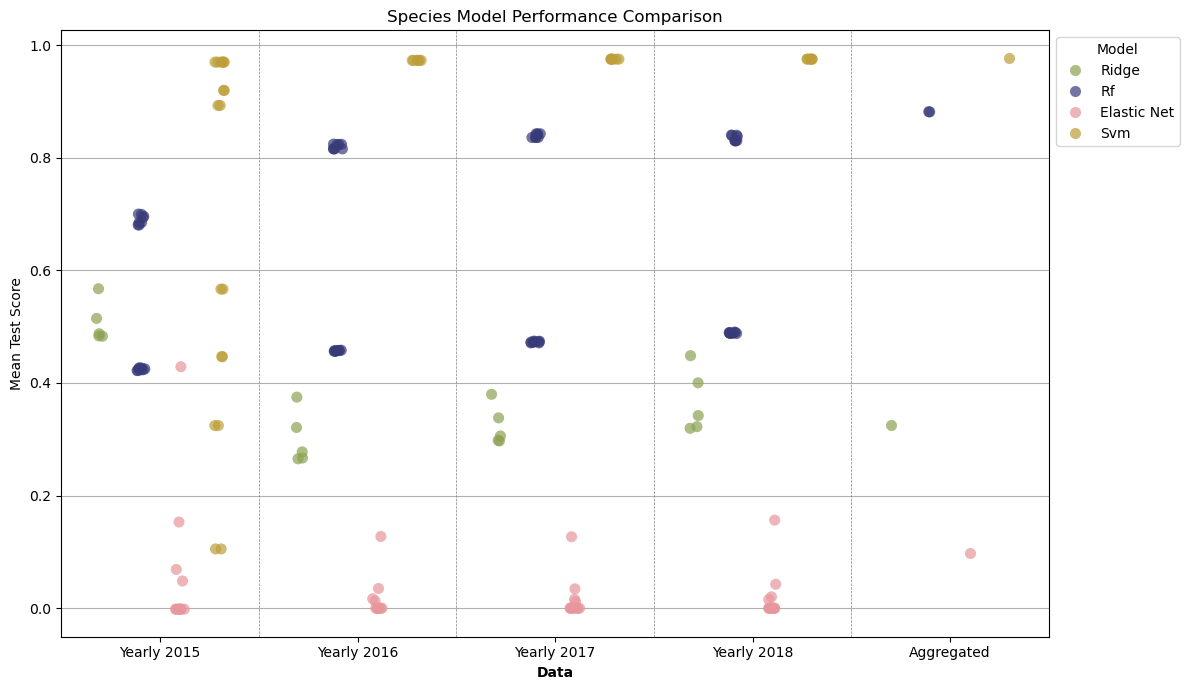

In [85]:
# Set the figure size
plt.figure(figsize=(12, 7))

tab20b = plt.get_cmap('tab20b')
cmap = {
    "Rf": tab20b(0),
    "Ridge": tab20b(5),
    "Elastic Net": tab20b(15),
    "Svm": tab20b(9)
}
palette = {model: color for model, color in cmap.items()}


# Create the stripplot
ax = sns.stripplot(data=df_combined, x='data_type', y='mean_test_score', hue='model_name', dodge=True, jitter=True, size=8, alpha=0.7, palette=palette)

# Clean up the plot
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Mean Test Score')
plt.title('Species Model Performance Comparison')

ax.grid(False)

# Drawing vertical lines between ticks
ticks = ax.get_xticks()
for i in range(len(ticks)-1):
    mid_point = (ticks[i] + ticks[i+1]) / 2
    plt.axvline(mid_point, color='grey', linestyle='--', lw=0.5)

ax.yaxis.grid(True)

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Model', loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.savefig('/home/rfreund/amr_driams/rasmus/data/DRIAMS-A/ml_models/aggregated/combined_plot.png', dpi=300)
plt.show()


## Resistance RF

In [20]:
# Load the data and create train / test split
data_loader = DataLoader(csv_file_path='/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_train_val.csv',
                         data_dir_path='/faststorage/project/amr_driams/data/DRIAMS-A/binned_6000/2015/', 
                         training_target='resistance',
                         num_workers=2)

total_data_points = len(data_loader.data_references)

# Load dataset
X, y = [], []
for data, label in tqdm(data_loader.data_generator(), total=total_data_points, desc="Loading Data"):
    X.append(data)
    y.append(label)

X = np.array(X)
y = np.array(y)

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X, y,
    test_size=0.20
)



Loading Data: 100%|███| 2714/2714 [00:59<00:00, 45.49it/s]


In [7]:
print(len(X_test))
print(len(y_test))

5056
5056


In [19]:
## Random Forest

# Initialise model
rf = RandomForestClassifier(random_state=42)

# Define parameter grid for CV
param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

# Set up grid search
grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid,
                              cv=5,
                              n_jobs=-1,
                              verbose=2)

# Run fit
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

# Save the best parameters and score to a text file
results_dir = os.path.dirname(data_loader.csv_file_path)  # Get the directory of the CSV file
results_file_name = "rf_resistance_best_params.txt"
results_file_path = os.path.join(results_dir, results_file_name)
with open(results_file_path, 'w') as file:
    file.write(f"Best Parameters: {best_params}\n")
    file.write(f"Best Score: {best_score}\n")

# Extract and save the CV results
save_path = os.path.join(results_dir, 'rf_resistance_cv_results.csv')
save_cv_results(grid_search_rf.cv_results_, save_path)

# Print best parameters and score
print("Best Parameters:" ,best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
CV results saved to /faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/rf_resistance_cv_results.csv
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.24678586632609623


# Plot resistance model performance

In [4]:
base_dir_yearly = '/home/rfreund/amr_driams/rasmus/data/DRIAMS-A/ml_models/'
resistance_dirs = []
base_dir_aggregated = '/home/rfreund/amr_driams/rasmus/data/DRIAMS-A/ml_models/aggregated/resistance'
years = ['2015', '2016', '2017', '2018']

for base, dir, files in os.walk(base_dir_yearly):
    if "aggregated" in base:
        continue
    if base.endswith("resistance"):
        resistance_dirs.append(base)
resistance_dirs = sorted(resistance_dirs)

data = []

for path in range(len(resistance_dirs)):
    for file in os.listdir(resistance_dirs[path]):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(resistance_dirs[path], file))
            for idx, row in df.iterrows():
                if "rf" in file:
                    data.append([row['mean_test_score'], row['std_test_score'], years[path], "Random Forest"])
                elif "ridge" in file:
                    data.append([row['mean_test_score'], row['std_test_score'], years[path], "Ridge"])

for file in os.listdir(base_dir_aggregated):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(base_dir_aggregated, file))
        for idx, row in df.iterrows():
            if "rf" in file:
                data.append([row['mean_test_score'], row['std_test_score'], 'Aggregated', "Random Forest"])
            elif "ridge" in file:
                data.append([row['mean_test_score'], row['std_test_score'], 'Aggregated', "Ridge"])
            
df_resistance = pd.DataFrame(data, columns=['mean_test_score', 'std_test_score', 'data_type', 'model'])

print(df_resistance)



    mean_test_score  std_test_score   data_type  model
0          0.182814        0.041166        2015  Ridge
1          0.182659        0.041065        2015  Ridge
2          0.182191        0.039566        2015  Ridge
3          0.185250        0.040709        2015  Ridge
4          0.138262        0.028722        2015  Ridge
..              ...             ...         ...    ...
94         0.057618        0.001917  Aggregated  Ridge
95         0.057606        0.001918  Aggregated  Ridge
96         0.057429        0.001856  Aggregated  Ridge
97         0.056371        0.002048  Aggregated  Ridge
98         0.051766        0.001791  Aggregated  Ridge

[99 rows x 4 columns]


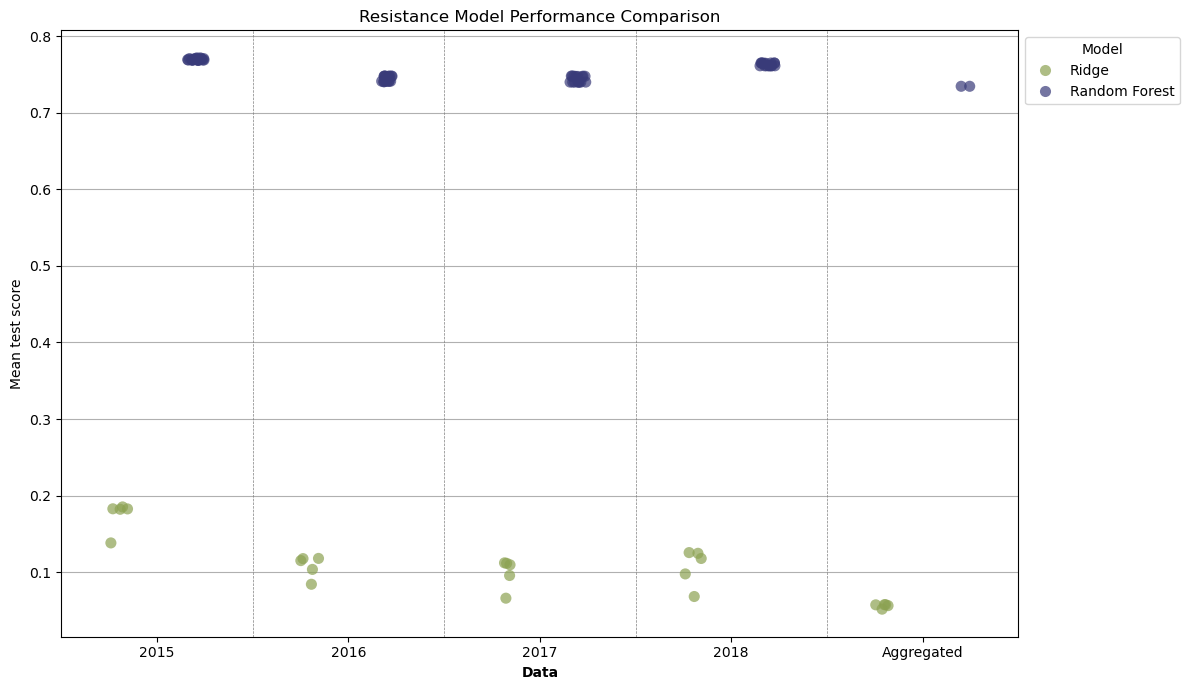

In [5]:
# Set the figure size
plt.figure(figsize=(12, 7))


tab20b = plt.get_cmap('tab20b')
cmap = {
    "Random Forest": tab20b(0),
    "Ridge": tab20b(5)
}
palette = {model: color for model, color in cmap.items()}

# Create the stripplot
ax = sns.stripplot(data=df_resistance, x='data_type', y='mean_test_score', hue='model', dodge=True, jitter=True, size=8, alpha=0.7, palette=palette)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Model', loc='upper left', bbox_to_anchor=(1,1))

ax.grid(False)

# Drawing vertical lines between ticks
ticks = ax.get_xticks()
for i in range(len(ticks)-1):
    mid_point = (ticks[i] + ticks[i+1]) / 2
    plt.axvline(mid_point, color='grey', linestyle='--', lw=0.5)

ax.yaxis.grid(True)

plt.xlabel('Data', fontweight='bold')
plt.ylabel('Mean test score')
plt.title('Resistance Model Performance Comparison')
plt.tight_layout()
plt.savefig('/home/rfreund/amr_driams/rasmus/Figures/models/aggregated/resistance_rf_comparison.png', dpi=300)
plt.show()

# Resistance model fitting for performance evaluation

In [27]:
# Train model
rf_classifier = RandomForestClassifier(max_depth=10,
                                       max_features='sqrt',
                                       min_samples_leaf=3,
                                       min_samples_split=2,
                                       n_estimators=200)
rf_classifier.fit(X_train, y_train)

# Create predictions
y_score = rf_classifier.predict_proba(X_test)

In [21]:
# Train model (Ridge)
ridge_clf = make_pipeline(StandardScaler(), RidgeClassifier())
ridge_clf.fit(X_train, y_train)

y_scores = ridge_clf.decision_function(X_test)

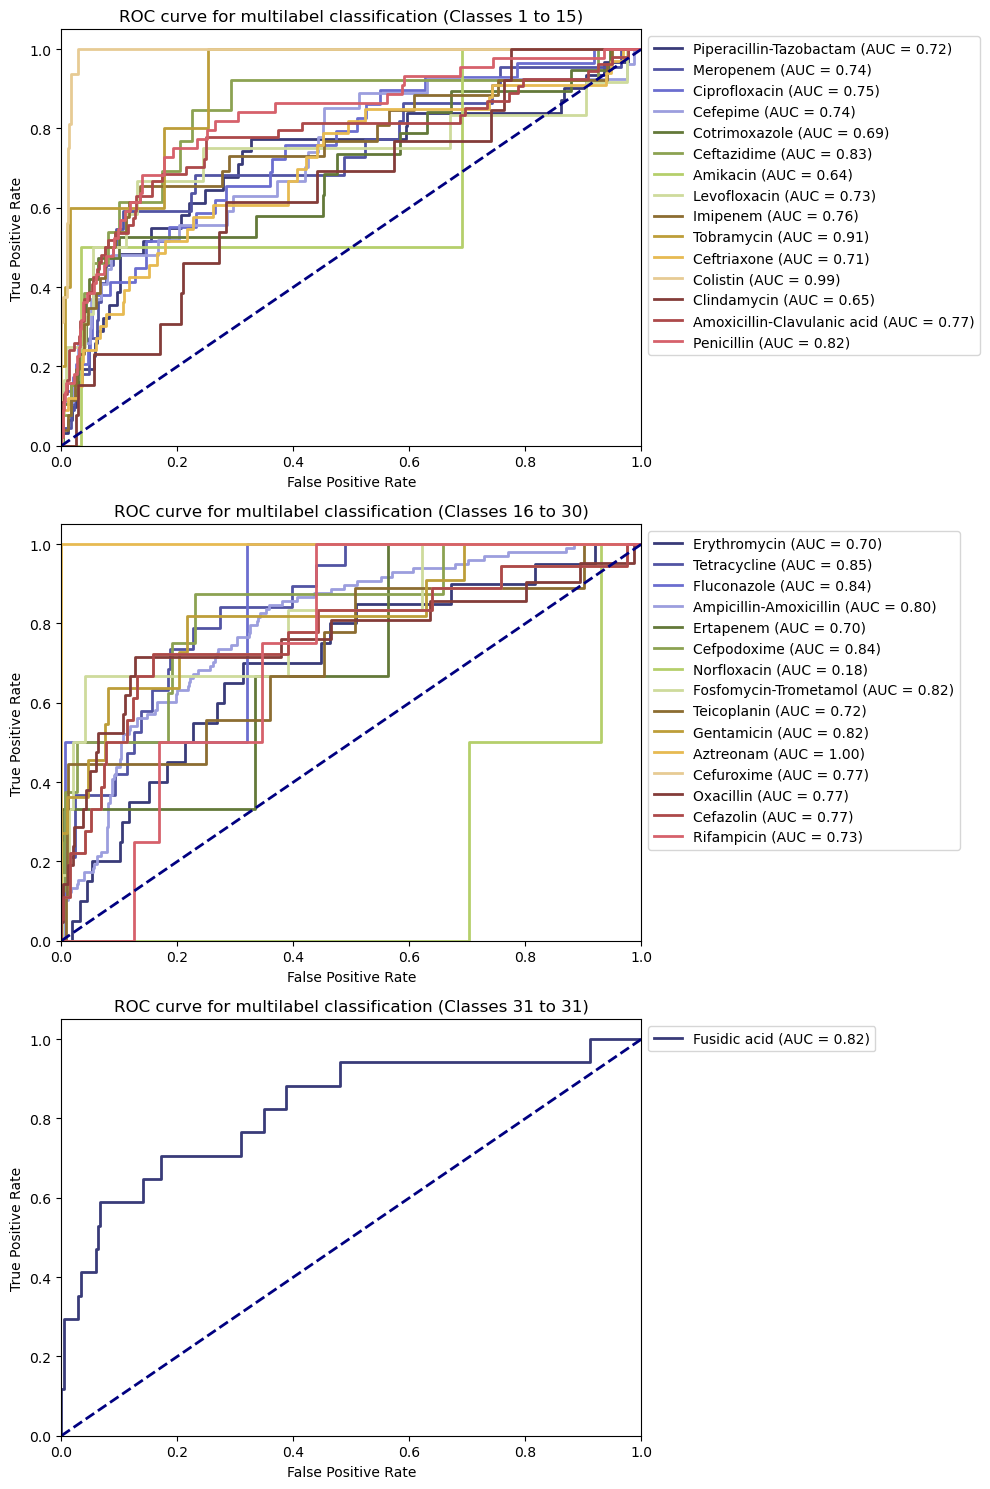

In [22]:
labels = np.array(y_test)
labels_df = pd.DataFrame(labels, columns=data_loader.label_columns)
predictions_df = pd.DataFrame(y_scores, columns=labels_df.columns)

plot_roc_curve(predictions_df, labels_df, save_path="/faststorage/project/amr_driams/rasmus/Figures/models/2015/ROC_curves_ridge.png")

In [8]:
def plot_roc_curve(predictions: pd.DataFrame, labels: pd.DataFrame, max_classes_per_plot: int=15, save_path: str = None):
    """
    Plot ROC curve for each label.
    Parameters:
    predictions: DataFrame of label predictions (estimated probabilities, not classes) with shape of (n_sample, n_class).
    labels: DataFrame of ground truth labels with shape of (n_sample, n_class).
    max_classes_per_plot: Maximum number of classes to display in each subplot
    """
    n_classes = predictions.shape[1]
    n_plots = int(np.ceil(n_classes / max_classes_per_plot))
    colors = plt.colormaps['tab20b']
    lw = 2
    
    # Create subplots
    fig, axes = plt.subplots(n_plots, 1, figsize=(10, n_plots * 5))
    if n_plots == 1:
        axes = [axes]

    for plot_idx in range(n_plots):
        start_idx = plot_idx * max_classes_per_plot
        end_idx = min((plot_idx + 1) * max_classes_per_plot, n_classes)

        for i in range(start_idx, end_idx):
            fpr, tpr, _ = roc_curve(labels.iloc[:, i], predictions.iloc[:, i])
            roc_auc = auc(fpr, tpr)
            color = colors(i - start_idx)

            axes[plot_idx].plot(fpr, tpr, color=color, lw=lw,
                                label=f'{predictions.columns[i]} (AUC = {roc_auc:.2f})')
        axes[plot_idx].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        axes[plot_idx].set_xlim([0.0, 1.0])
        axes[plot_idx].set_ylim([0.0, 1.05])
        axes[plot_idx].set_xlabel('False Positive Rate')
        axes[plot_idx].set_ylabel('True Positive Rate')
        axes[plot_idx].set_title(f'ROC curve for multilabel classification (Classes {start_idx+1} to {end_idx})')
        axes[plot_idx].legend(loc='upper left', bbox_to_anchor=(1,1))

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true

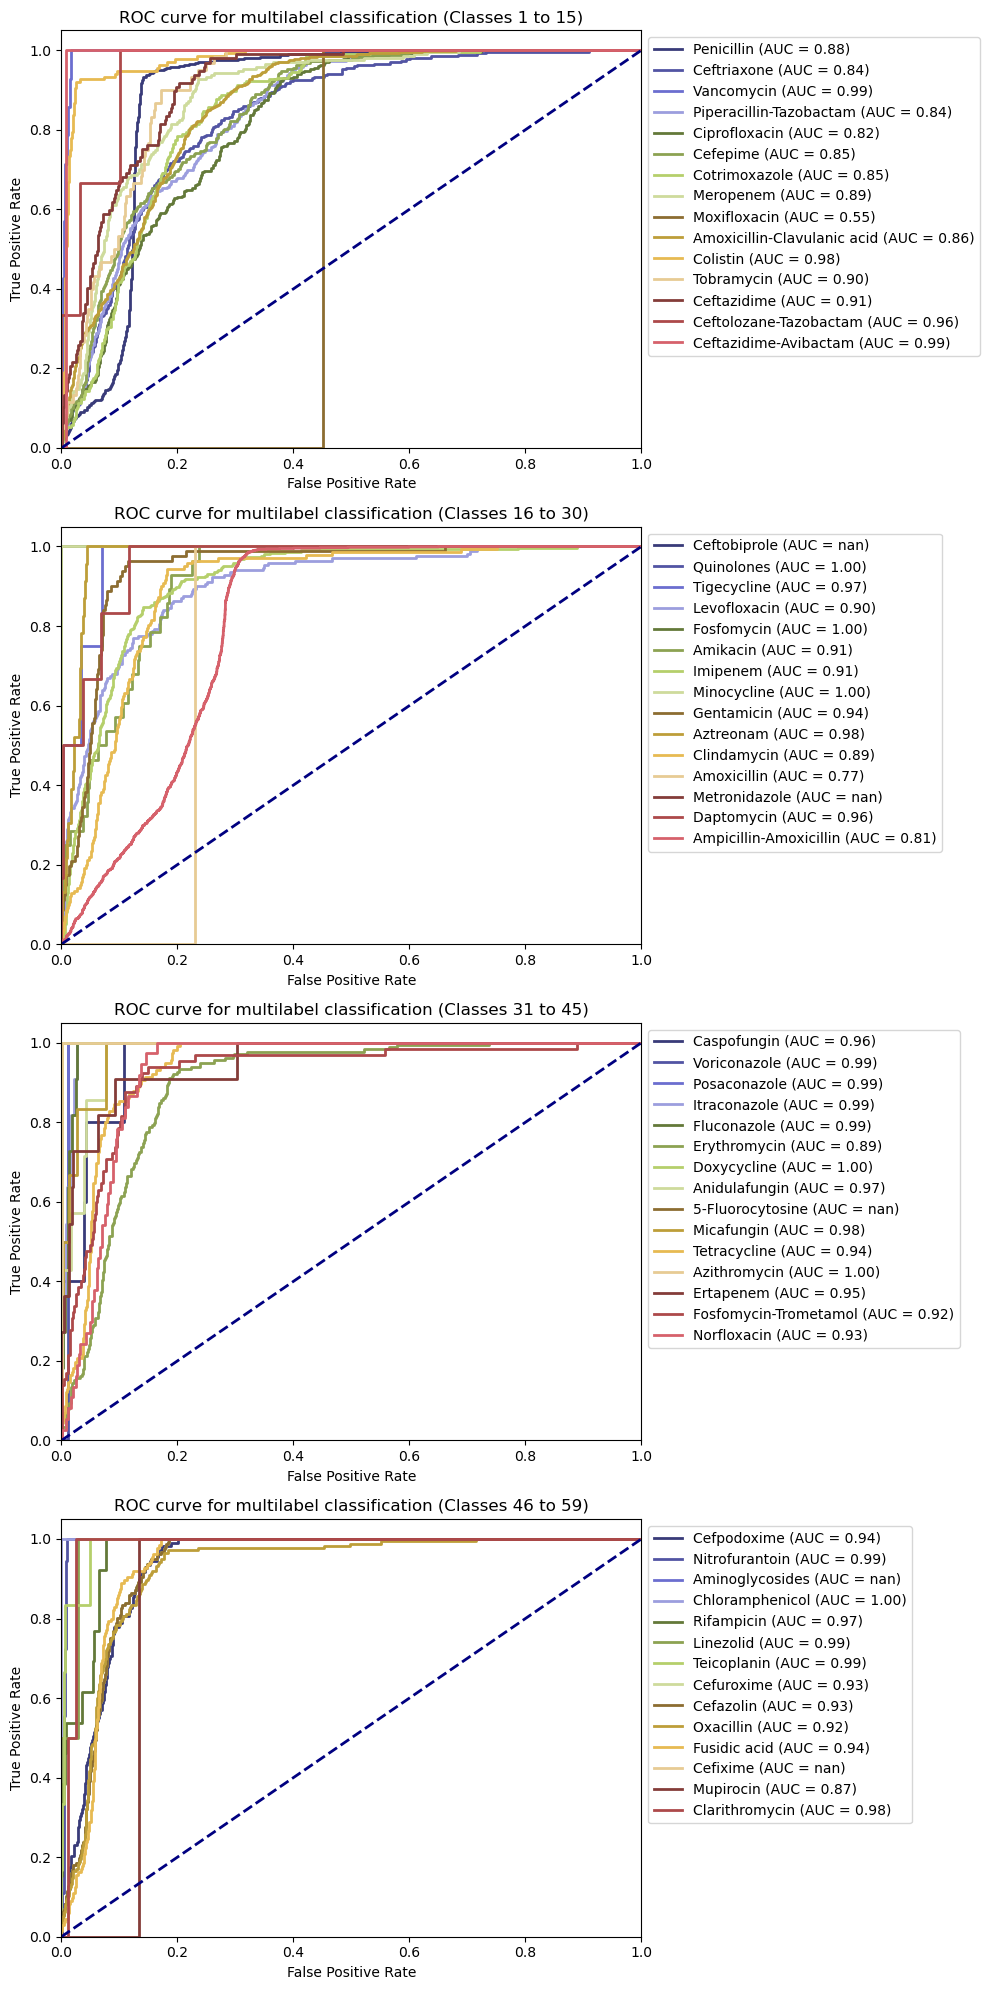

In [28]:
# Check if .predict_proba is returning one or two columns
probabilities = np.array([probs[:, -1] for probs in y_score]).T
labels = np.array(y_test)

predictions_df = pd.DataFrame(probabilities, columns=data_loader.label_columns)
labels_df = pd.DataFrame(labels, columns=data_loader.label_columns)

plot_roc_curve(predictions_df, labels_df, save_path = '/faststorage/project/amr_driams/rasmus/Figures/models/2018/ROC_curves.png')

# Data distribution

In [5]:
def analyse_species_distribution(csv_file_path: str, percentile: float = None, top_species_count: int = None, plot_hist: bool = True, plot_cumsum: bool = False):
    """
    Analyses species distribution from a given CSV file, plots histogram and/or cumulative sum of species frequencies,
    and returns species that makes up the n-th percentile of the dataset.

    Parameters:
    csv_file_path: Path to the CSV file.
    percentile: The percentile of the dataset to compute the species composition for (e.g., 80 for the 80th percentile).
    top_species_count: The number of top species to provide information on.
    plot_hist: Whether to plot a histogram of species counts.
    plot_cumsum: Whether to plot the cumulative sum of species frequencies.
    """

    # Check exclusivity of percentile and top_species_count
    if percentile and top_species_count:
        raise ValueError('Only one of percentile or top_species_count should be specified.')
    
    data_df = pd.read_csv(csv_file_path, low_memory=False)

    species_counts = data_df['species'].value_counts().sort_values(ascending=False)
    cumsum_percent = species_counts.cumsum() / species_counts.sum() * 100

    selected_species = None
    cumulative_percentage = cumsum_percent.iloc[top_species_count - 1]

    base_path = os.path.split(csv_file_path)[0]
    
    if plot_hist:
        plt.figure(figsize=(15,8))
        if top_species_count and 0 < top_species_count < len(species_counts):
            # Separate the top n species and sum the rest
            top_species = species_counts[:top_species_count]
            remaining_count = species_counts[top_species_count:].sum()
            counts_to_plot = pd.Series(top_species.tolist() + [remaining_count],
                                       index=top_species.index.tolist() + ['Remaining Species'])
            colors = ['cornflowerblue'] * top_species_count + ['lightgray']
        else:
            counts_to_plot = species_counts
            colors = 'cornflowerblue'

        counts_to_plot.plot(kind='bar', width=0.8, color=colors, edgecolor='cornflowerblue')
        plt.xlabel('Species')
        plt.ylabel('Log-transformed Count')
        plt.title('Species Distribution')
        plt.xticks(ticks=np.arange(len(counts_to_plot)), labels=counts_to_plot.index, rotation=90)
        plt.autoscale(enable=True, axis='x', tight=False)
        plt.yscale('log')
        plt.tight_layout()
        plt.savefig(os.path.join(base_path, '2015_distribution.png'), dpi=300)
        plt.show()

    if plot_cumsum:
        plt.figure(figsize=(15,8))
       
        cumsum_percent = species_counts.cumsum() / species_counts.sum() * 100
        if top_species_count and 0 < top_species_count < len(species_counts):
            plt.plot(cumsum_percent.index[:top_species_count], cumsum_percent.values[:top_species_count], marker='o', color='cornflowerblue', label='Top Species')
            remaining_cumsum = cumsum_percent.values[top_species_count-1] + (species_counts.values[top_species_count:].sum() / species_counts.sum() * 100)
            plt.scatter(['Remaining Species'], [remaining_cumsum], color='orange', label='Remaining Species', zorder=3) 
        else:
            plt.plot(cumsum_percent.index, cumsum_percent.values, marker='o', color='cornflowerblue', label='All Species')

        plt.xlabel('Species')
        plt.ylabel('Cumulative Percentage')
        plt.title('Cumulative Sum of Species Frequencies')
        plt.grid(color='lightgray', linestyle='--', linewidth=0.5, axis='y', zorder=2)
        subtitle_text = f'Top {top_species_count} Species Cumulative Percentage: {round(cumulative_percentage, 2)}%' if top_species_count else ''
        plt.suptitle(subtitle_text, fontsize=10, x=0.514, y=0.88)
        plt.xticks(rotation=90)
        plt.autoscale(enable=True, axis='x', tight=False)
        plt.tight_layout()
        plt.savefig(os.path.join(base_path, '2015_cumsum_top10.png'), dpi=300)    
        plt.show()

    percentile_species = None
    if percentile:
        # Calculate the minimal set of species making up the n-th percentile
        selected_species = cumsum_percent[cumsum_percent <= percentile].index.tolist()
    elif top_species_count:
        # Select the top n species
        selected_species = species_counts.iloc[:top_species_count].index.tolist()

    if selected_species:
        print(f'Selected species: {selected_species}')
        with open(os.path.join(base_path, 'selected_species.txt'), 'w') as f:
            f.write(f'Top {top_species_count} species\n')
            for species in selected_species:
                f.write(f'{species}\n')
                
    if cumulative_percentage:
        print(f'Cumulative percentage of top {top_species_count} species: {cumulative_percentage}%')

    return selected_species, cumulative_percentage


In [6]:
paths_A = sorted(ID_PATHS[:4])

species_2015, percentage_2015 = analyse_species_distribution(paths_A[0], top_species_count=25, plot_hist=False, plot_cumsum=False)
species_2016, percentage_2016 = analyse_species_distribution(paths_A[1], top_species_count=25, plot_hist=False, plot_cumsum=False)
species_2017, percentage_2017 = analyse_species_distribution(paths_A[2], top_species_count=25, plot_hist=False, plot_cumsum=False)
species_2018, percentage_2018 = analyse_species_distribution(paths_A[3], top_species_count=25, plot_hist=False, plot_cumsum=False)


Selected species: ['Staphylococcus epidermidis', 'Escherichia coli', 'Enterococcus faecalis', 'Gardnerella vaginalis', 'Staphylococcus aureus', 'Pseudomonas aeruginosa', 'Streptococcus agalactiae', 'Klebsiella pneumoniae', 'Propionibacterium acnes', 'Enterobacter cloacae', 'Candida albicans', 'Streptococcus anginosus', 'Proteus mirabilis', 'Serratia marcescens', 'Enterococcus faecium', 'Morganella morganii', 'Lactobacillus crispatus', 'Citrobacter freundii', 'Candida glabrata', 'Corynebacterium tuberculostearicum', 'Lactobacillus gasseri', 'Staphylococcus hominis', 'Stenotrophomonas maltophilia', 'Citrobacter koseri', 'Staphylococcus haemolyticus']
Cumulative percentage of top 25 species: 58.38023764853033%
Selected species: ['Staphylococcus epidermidis', 'Staphylococcus aureus', 'Escherichia coli', 'Gardnerella vaginalis', 'Pseudomonas aeruginosa', 'Enterococcus faecalis', 'Klebsiella pneumoniae', 'Propionibacterium acnes', 'Streptococcus agalactiae', 'Candida albicans', 'Streptococcu

In [22]:
def analyse_species_distribution_stacked(csv_file_paths: list[str], top_species_count: int):
    master_species_list = set()
    for path in csv_file_paths:
        data_df = pd.read_csv(path, low_memory=False)
        master_species_list.update(data_df['species'].unique())

    master_species_list = sorted(master_species_list)

    num_plots = len(csv_file_paths)

    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 3 * num_plots), constrained_layout=True)

    if num_plots == 1:
        axes = [axes]

    for ax, path in zip(axes, csv_file_paths):
        year = os.path.basename(path).split('_')[0]
        data_df = pd.read_csv(path, low_memory=False)
        species_counts = data_df['species'].value_counts().sort_values(ascending=False)
        species_count = species_counts.sum()
        species_percent = species_counts / species_counts.sum() * 100

        top_species_percent = species_percent.iloc[:top_species_count]
        remaining_species_percent = species_percent.iloc[top_species_count:].sum()
        
        percentages = np.hstack([top_species_percent.cumsum(), remaining_species_percent + top_species_percent.cumsum().iloc[-1]])
        labels = top_species_percent.index.tolist() + ['Remaining Species']
        
        top_colors = plt.cm.tab20b(np.linspace(0, 1, top_species_count))
        colors = list(top_colors) + ['lightgray']

        for i, (percent, color) in enumerate(zip(percentages, colors)):
            left = percentages[i-1] if i > 0 else 0
            ax.barh(year, percent - left, left=left, color=color)

        ax.set_xlabel('Percentage')
        ax.set_title(f'Species Distribution in {year} (N={species_count})')
        ax.legend(labels, title='Species', bbox_to_anchor=(1, 1.05), loc='upper left')
    plt.savefig('/faststorage/project/amr_driams/rasmus/Figures/data_visualisation/aggregated/species_distribution.png', dpi=300)
    plt.show()


In [23]:
paths = [os.path.split(path)[0] for path in paths_A]
paths_filtered = []
for path in os.listdir(paths[0]):
    if path.endswith("train_test.csv"):
        paths_filtered.append(os.path.join(paths[0], path))
paths_filtered = sorted(paths_filtered)


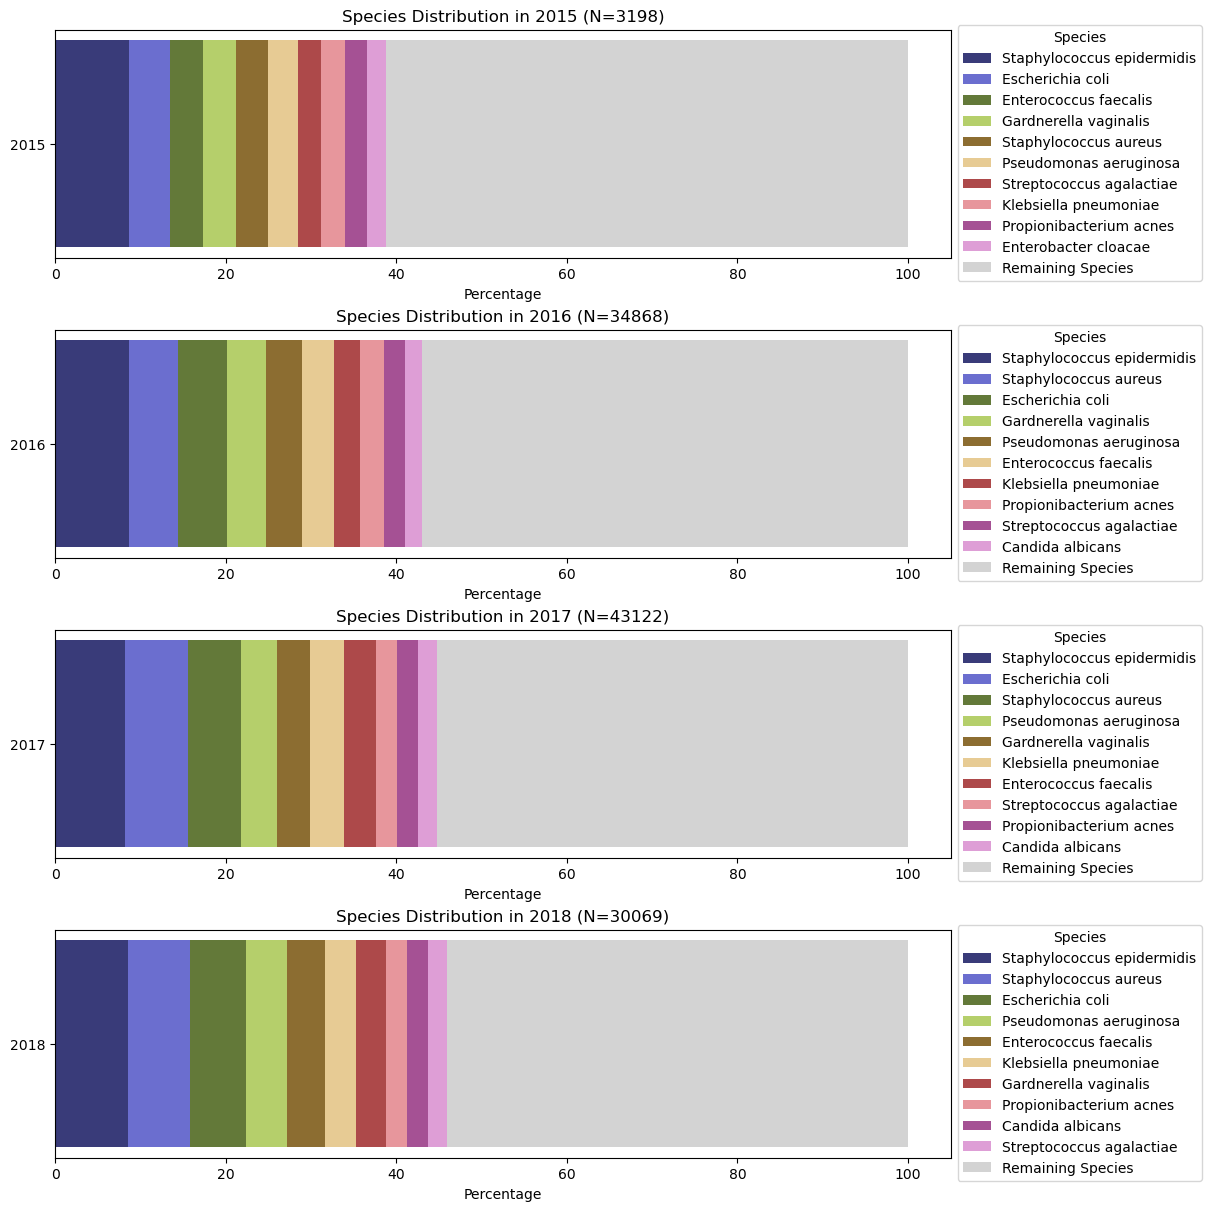

In [25]:
analyse_species_distribution_stacked(paths_A, 10)

In [6]:
print(paths_A)

['/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2015_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2016_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2017_clean.csv', '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2018_clean.csv']


In [62]:
def plot_antibiotic_resistances(csv_file_path: str, selected_species: list[str]):
    """
    Creates a bar plot for the frequency of different antibiotic resistances,
    excluding columns with an '_' in their name. Each bar is colored with the
    contribution of each species from the selected_species list.

    Parameters:
    csv_file_path: Path to the CSV file.
    selected_species: List of species to highlight in the plot.
    """

    data_df = pd.read_csv(csv_file_path, low_memory=False)

    # Filter columns
    antibiotic_cols = [col for col in data_df.columns[3:] if '_' not in col]
    for i in antibiotic_cols:
        if i == 'species':
            antibiotic_cols.remove('species')
            
    # Initialise a color map
    cmap = plt.get_cmap('tab20b', len(selected_species))
    species_cmap = {species: cmap(i) for i, species in enumerate(selected_species)}

    plt.figure(figsize=(15,8))

    # Total counts for each antibiotic
    total_counts = data_df[antibiotic_cols].apply(lambda x: x.isin(['R', 'I']).sum())
    total_counts_sorted = total_counts.sort_values(ascending=False)

    # Plot total counts
    bars = plt.bar(total_counts_sorted.index, total_counts_sorted, color='lightgrey', label='Total Resistance')

    # Plot contribution from each species
    for i, species in enumerate(selected_species):
        species_df = data_df[data_df['species'] == species]
        species_counts = species_df[antibiotic_cols].apply(lambda x: x.isin(['R', 'I']).sum())
        species_counts_sorted = species_counts[total_counts_sorted.index]

        bottom = np.zeros(len(species_counts_sorted))
        if i > 0:
            for prev_species in selected_species[:i]:
                prev_species_counts = data_df[data_df['species'] == prev_species][antibiotic_cols].apply(lambda x: x.isin(['R', 'I']).sum())[total_counts_sorted.index]
                bottom += prev_species_counts.values
            
        plt.bar(species_counts_sorted.index, species_counts_sorted, bottom=bottom, color=species_cmap[species], label=species)
    
    plt.xticks(rotation=90)
    plt.xlabel('Antibiotic')
    plt.ylabel('Log-transformed Frequency of Resistance')
    plt.title('Antibiotic Resistance Distribution')
    plt.legend()
    plt.tight_layout()
    plt.yscale('log')
    
    plt.savefig('/faststorage/project/amr_driams/rasmus/Figures/data_visualisation/antibiotic_resistance_distribution.png', dpi=300)
    plt.show()
    

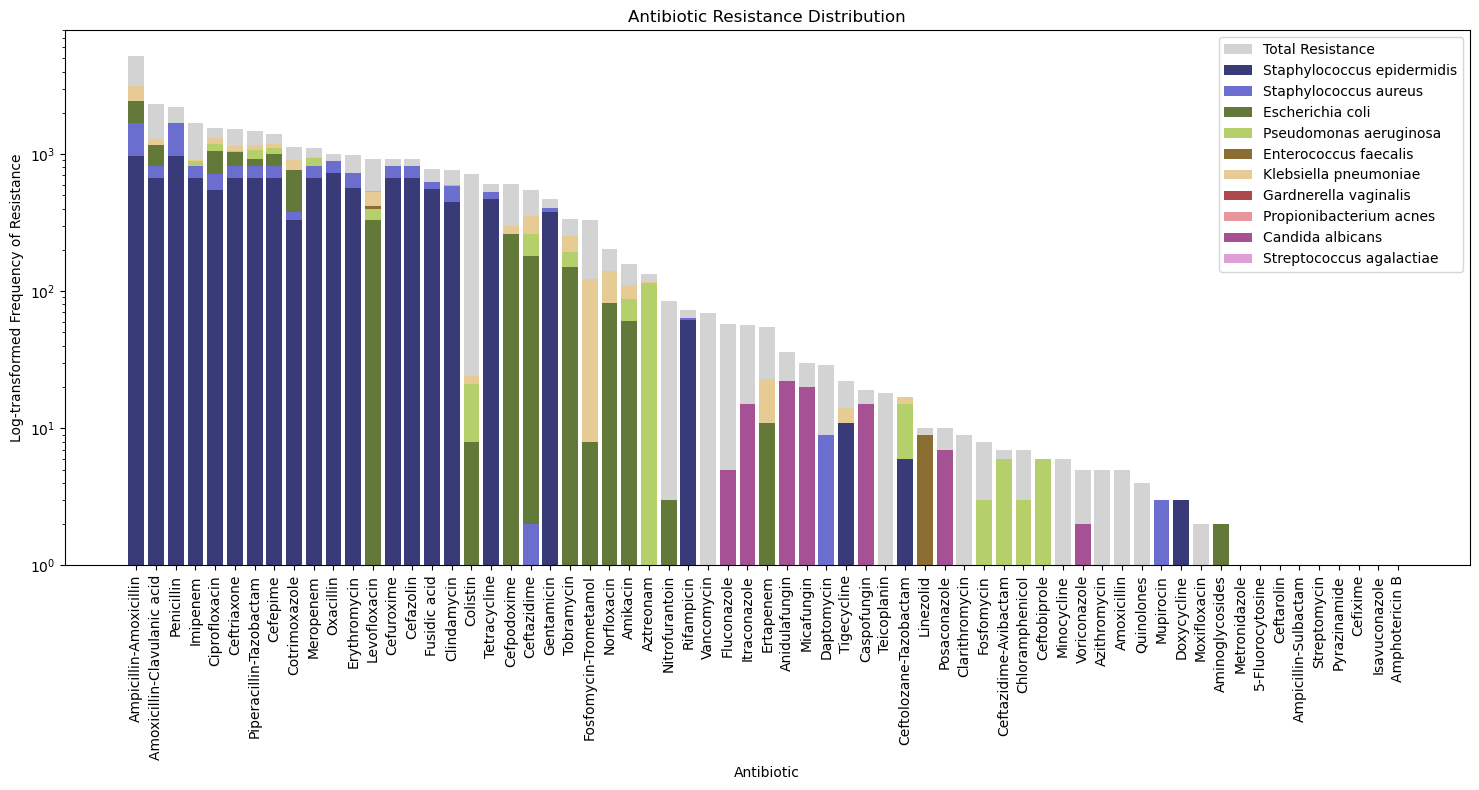

In [67]:
plot_antibiotic_resistances(paths_filtered[3], species_2018)

# PCA

In [114]:
def plot_DR(model, labels, data_loader, species_to_color: list[str], save_path: str, UMAP: bool=False, plot_remaining: bool=False):
    # Convert to DataFrame
    X_dr = pd.DataFrame(model)
    # Add labels to DataFrame
    species = []
    for label in labels:
        if list(data_loader.label_mapping.keys())[label] in species_to_color:
            species.append(list(data_loader.label_mapping.keys())[label])
        else:
            species.append('Remaining Species')
    X_dr.insert(2, 'species', species)
    
    # Add colors based on species label
    top_colors = plt.cm.tab20b(np.linspace(0, 1, len(species_to_color)))
    color = []
    for i in X_dr['species']:
        if i in species_to_color:
            color.append(top_colors[species_to_color.index(i)])
        else:
            color.append('lightgray')
    X_dr.insert(3, 'color', color)

    # Create plot
    fig, ax = plt.subplots()
    for species, group in X_dr.groupby('species'):
        if species != 'Remaining Species' or plot_remaining:
            ax.scatter(group[0], group[1], label=species, c=group['color'], alpha=.7)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    if UMAP:
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_title('UMAP of dataset by species')
        plt.savefig(os.path.join(save_path, 'UMAP_species_noRemaining.png'), dpi=300, bbox_inches='tight')
    else:
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_title('PCA of dataset by species')
        plt.savefig(os.path.join(save_path, 'PCA_species_noRemaining.png'), dpi=300, bbox_inches='tight')
    
    plt.show()

In [103]:
# Load the data without one-hot encoding
data_loader = DataLoader(csv_file_path='/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/2015_clean_stratified.csv',
                         data_dir_path='/faststorage/project/amr_driams/data/DRIAMS-A/binned_6000/2015/',
                         num_workers=1,
                         training_target="species",
                         one_hot_encode=False)
#print(len(data_loader.label_mapping))

total_data_points = len(data_loader.data_references)

In [104]:
X, y = [], []
for data, label in tqdm(data_loader.data_generator(), total=total_data_points, desc="Loading Data"):
    X.append(data)
    y.append(label)

X = np.array(X)
y = np.array(y)


Loading Data: 100%|████████████████████| 2815/2815 [00:14<00:00, 199.13it/s]


In [110]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)
X_pca = np.ascontiguousarray(X_pca)
# For creating a plot of PC 3 and 4; don't forget to change labels in the plot function!
#X_pca = X_pca[:, [2, 3]]


[[ 0.0096629   0.00291929]
 [-0.00711256  0.01674253]
 [ 0.00851197  0.00291027]
 ...
 [ 0.00803487  0.00260492]
 [-0.00248365 -0.00423094]
 [ 0.00811585  0.00161366]]


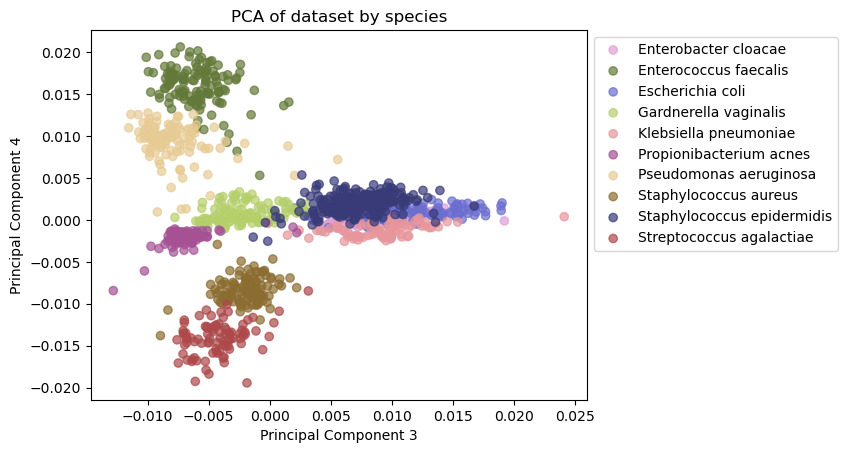

In [112]:
save_path = '/home/rfreund/amr_driams/rasmus/Figures/data_visualisation/2015/'

plot_DR(X_pca, y, data_loader, species_2015, save_path, UMAP=False)

# UMAP

In [113]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)
unique_labels = np.unique(y)

/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


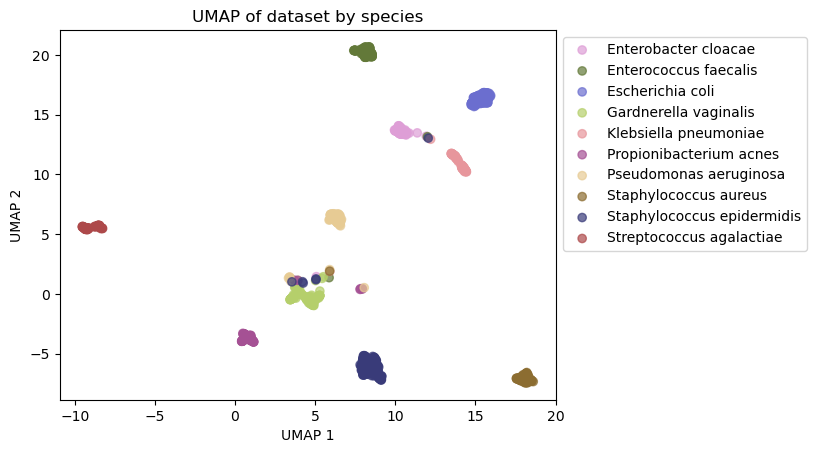

In [115]:
save_path = '/home/rfreund/amr_driams/rasmus/Figures/data_visualisation/2015/'

plot_DR(X_umap, y, data_loader, species_2015, save_path, UMAP=True)

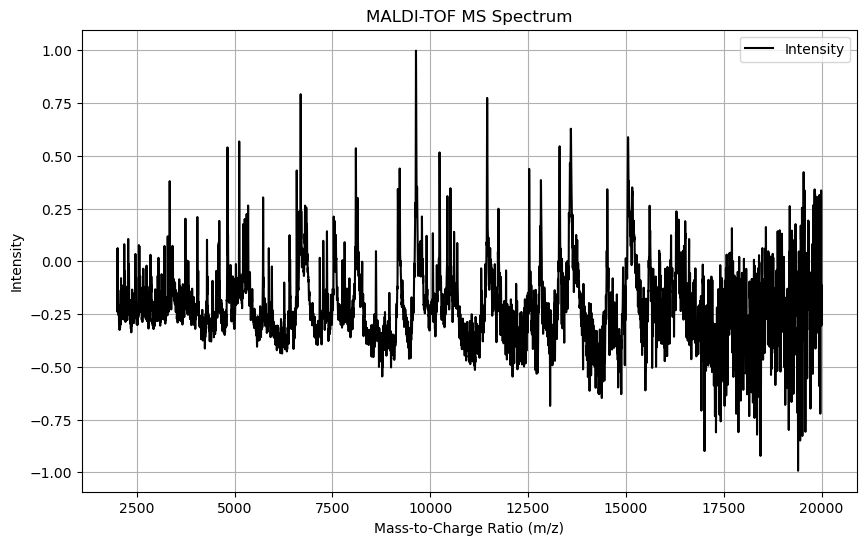

In [28]:
file_path = '/home/rfreund/amr_driams/data/DRIAMS-A/preprocessed_raw/2016/4fb6fc70-fd50-45e4-aeee-470e6b5f0198.txt'
# Reading the data from the file
data = pd.read_csv(file_path)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data['mass'], data['int'], color='black', label='Intensity')
plt.xlabel('Mass-to-Charge Ratio (m/z)')
plt.ylabel('Intensity')
plt.title('MALDI-TOF MS Spectrum')
plt.legend()
plt.grid(True)
plt.savefig('/home/rfreund/amr_driams/rasmus/Figures/data_visualisation/MALDITOFMS_spectrum.png', dpi=300)
plt.show()


